## Divvy Bike Share Analysis

In [1]:
import pandas as pd
import numpy  as np
Mar_2023 = pd.read_csv("202303-divvy-tripdata.csv")
Apr_2023 = pd.read_csv("202304-divvy-tripdata.csv")
May_2023 = pd.read_csv("202305-divvy-tripdata.csv")
Jun_2023 = pd.read_csv("202306-divvy-tripdata.csv")
Jul_2023 = pd.read_csv("202307-divvy-tripdata.csv")
Aug_2023 = pd.read_csv("202308-divvy-tripdata.csv")
Sep_2023 = pd.read_csv("202309-divvy-tripdata.csv")
Oct_2023 = pd.read_csv("202310-divvy-tripdata.csv")
Nov_2023 = pd.read_csv("202311-divvy-tripdata.csv")
Dec_2023 = pd.read_csv("202312-divvy-tripdata.csv")
Jan_2024 = pd.read_csv("202401-divvy-tripdata.csv")
Feb_2024 = pd.read_csv("202402-divvy-tripdata.csv")


In [2]:
data = [Mar_2023, Apr_2023, May_2023, Jan_2024, Jul_2023, Aug_2023, Sep_2023, Oct_2023, Nov_2023, Dec_2023, Jan_2024, Feb_2024]

# Create a dataframe and verify the dimensions 
df = pd.concat(data, ignore_index=True)
print(df.shape)

# Unify the format of started_at and ended_at columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

print(df['started_at'].head())


(5132423, 13)
0   2023-03-16 08:20:34
1   2023-03-04 14:07:06
2   2023-03-31 12:28:09
3   2023-03-22 14:09:08
4   2023-03-09 07:15:00
Name: started_at, dtype: datetime64[ns]


### Process Data

In [3]:
# Create new columns
df['month'] = df['started_at'].dt.month
df['day'] = df['started_at'].dt.day_of_week
df['tripDuration'] = df['ended_at'] - df['started_at']
df['tripDuration'] = df['tripDuration'].dt.total_seconds().astype(int)

# Verify no discrepancies in the values of the columns member_type and rideable_type
values_member_type = df['member_casual'].value_counts()
print("Values of member_casual:", list(values_member_type.index))

values_rideable_type= df['rideable_type'].value_counts()
print("Values of rideable_type:", list(values_rideable_type.index))

# Identify duplicates & delete them 
value_counts = df['ride_id'].value_counts()
duplicates = value_counts[value_counts > 1]

df = df.drop_duplicates(subset=['ride_id'])
value_counts = df['ride_id'].value_counts()
duplicates = value_counts[value_counts > 1]
print("Number of duplicates(should be 0):", duplicates.sum())

# Identify trips with negative tripDuration and remove them
negative_trip_duration = (df['tripDuration'] < 0).sum()

df = df[df['tripDuration'] >= 0]
negative_trip_duration = (df['tripDuration'] < 0).sum()
print("Number of negative trips(should be 0):", negative_trip_duration)

# Remove rows wit NaN values
df = df.dropna()

df.to_csv('tripdata_cleaned.csv', index=False)
print("DataFrame successfully written to tripdata_cleaned.csv")


Values of member_casual: ['member', 'casual']
Values of rideable_type: ['electric_bike', 'classic_bike', 'docked_bike']
Number of duplicates(should be 0): 0
Number of negative trips(should be 0): 0
DataFrame successfully written to tripdata_cleaned.csv


### Analyze Data

Text(0.5, 1.0, 'User Count: Member vs Casual')

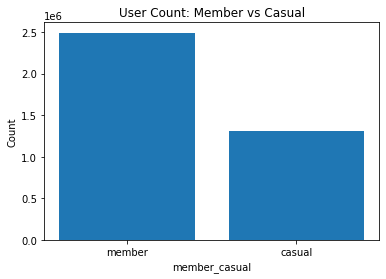

In [4]:
# Graph user count
import matplotlib.pyplot as plt
value_counts = df['member_casual'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('member_casual')
plt.ylabel('Count')
plt.title('User Count: Member vs Casual')


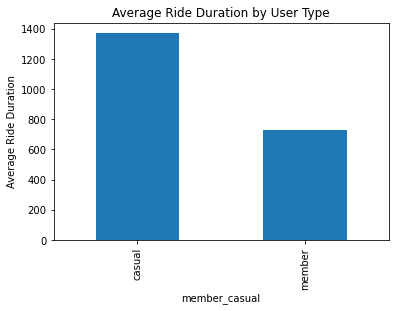

In [5]:
# Plot the ride duration between casual users & members 
average_duration = df.groupby('member_casual')['tripDuration'].mean()
average_duration.plot(kind='bar')
plt.xlabel('member_casual')
plt.ylabel('Average Ride Duration')
plt.title('Average Ride Duration by User Type')
plt.show()

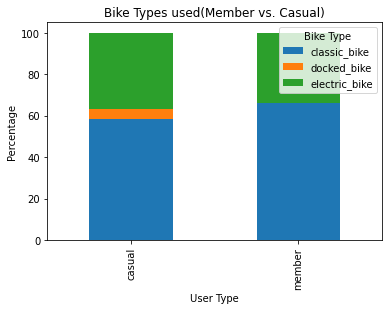

In [6]:
# Calculate the percentage of each rideable type for each group
percentage_df = df.groupby(['member_casual', 'rideable_type']).size().unstack(fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

# Plot the bar graph
percentage_df.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('User Type')
plt.ylabel('Percentage')
plt.title('Bike Types used(Member vs. Casual)')

# Show plot
plt.legend(title='Bike Type')
plt.show()

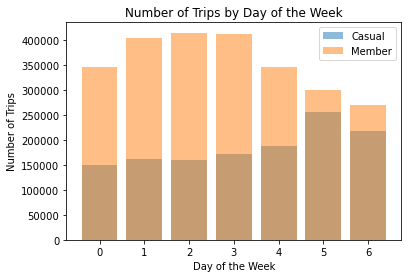

In [7]:
# Filter data for casual and member users
casual_data = df[df['member_casual'] == 'casual']
member_data = df[df['member_casual'] == 'member']

# Count the trips for each day of the week
casual_counts = casual_data['day'].value_counts().sort_index()
member_counts = member_data['day'].value_counts().sort_index()

# Plot the bar graph
plt.bar(casual_counts.index, casual_counts.values, label='Casual', alpha=0.5)
plt.bar(member_counts.index, member_counts.values, label='Member', alpha=0.5)

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of the Week')
plt.legend()

plt.show()

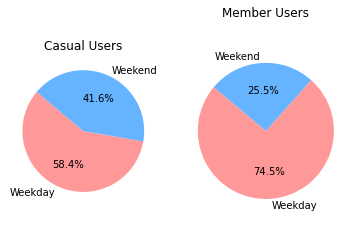

In [8]:
# Separate data into weekdays and weekends
weekday_data = df[df['day'] < 5]  # Monday to Friday
weekend_data = df[df['day'] >= 5]  # Saturday and Sunday

# Calculate total trip duration for weekdays and weekends for casual users
casual_weekday_duration = weekday_data[weekday_data['member_casual'] == 'casual']['tripDuration'].sum()
casual_weekend_duration = weekend_data[weekend_data['member_casual'] == 'casual']['tripDuration'].sum()

# Calculate total trip duration for weekdays and weekends for member users
member_weekday_duration = weekday_data[weekday_data['member_casual'] == 'member']['tripDuration'].sum()
member_weekend_duration = weekend_data[weekend_data['member_casual'] == 'member']['tripDuration'].sum()

# Plot pie charts
labels = ['Weekday', 'Weekend']
colors = ['#ff9999', '#66b3ff']

# Pie chart for casual users
plt.subplot(1, 2, 1)
sizes = [casual_weekday_duration, casual_weekend_duration]
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Casual Users')

# Pie chart for member users
plt.subplot(1, 2, 2)
sizes = [member_weekday_duration, member_weekend_duration]
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Member Users')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show plot
plt.show()


#### Findings(In-Progress)
- Majority of rides are from member users compared to casual users
- Casual riders have longer trip duration than member riders
- Docked bikes are the least popular type of bike used
- Casual riders have more trips on the weekend compared to member riders that have mroe trips on the weekdays. Tuesday to Thursday are the most popular days among member riders.